<a href="https://colab.research.google.com/github/RostislavKorst/Generative-Models-2023/blob/main/Assignment%202/2_mnist_cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2023, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


Let's continue our dive into the classical generative models! Today's goal is to implement Conditional GAN for MNIST dataset. Conditional image generation is the task of generating new images conditional on their class. Feel free to rewrite this skeleton or reuse your code from the previous assignment.

Good luck!

## 1. Conditional GAN
*Source: <a href="https://arxiv.org/pdf/1411.1784.pdf" target="_blank">Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014)</a>.*

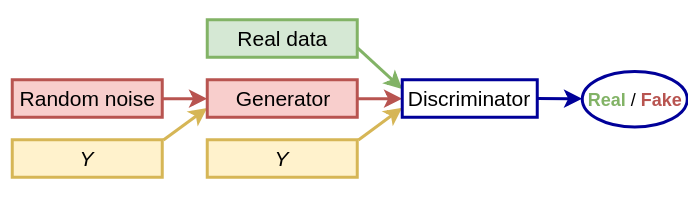

Picture source: https://medium.datadriveninvestor.com/an-introduction-to-conditional-gans-cgans-727d1f5bb011

### Imports

In [ ]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Some parameters

In [ ]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"
number_class = 10

if device == "cuda":
    !nvidia-smi

sample_dir = "./images"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Thu Jan 11 23:25:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Load dataset and create dataloader

In [ ]:
# Load MNIST dataset
mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 193398788.90it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105243869.53it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 110500445.73it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17721422.11it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

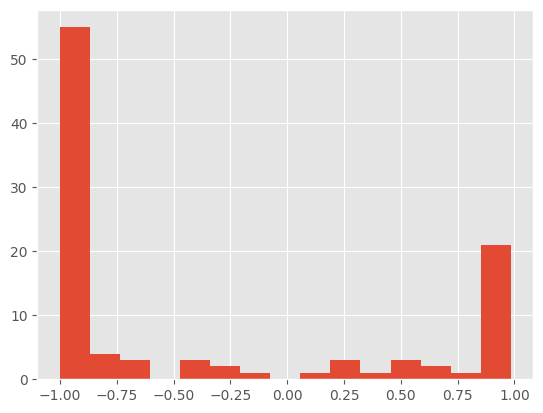

In [ ]:
# plot pixels distribution
img, label = mnist[0]
print('Label: ', label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [ ]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
  return (x + 1) / 2

Label:  5
Label: 5


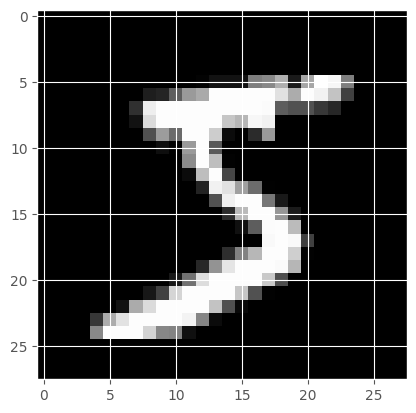

In [ ]:
# Let's plot something
img, label = mnist[0]
print("Label: ", label)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap="gray")
print("Label:", label)

### Define the models

Define the Discriminator network, the Generator network with additional input for condition

In [ ]:
number_class = 10

class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size, number_class):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(number_class, number_class)

        self.model = nn.Sequential(
            nn.Linear(latent_size + number_class, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Ensure labels are of the correct shape
        labels = labels.view(-1)  # Reshaping labels to be [batch_size]
        c = self.label_emb(labels)

        # Flatten the label embeddings if they have an extra dimension
        c = c.view(c.size(0), -1)  # Flattening to [batch_size, embedding_size]

        x = torch.cat([z, c], 1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, number_class):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(number_class, number_class)

        self.model = nn.Sequential(
            nn.Linear(image_size + number_class, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x.view(x.size(0), -1), c], 1)
        return self.model(x)

Answer the question: why the last layer of generator is $Tanh$ and the last discriminator layer is $Sigmoid$?

In [ ]:
# create new Generator model

G = Generator(latent_size, hidden_size, image_size, number_class).to(device)
D = Discriminator(image_size, hidden_size, number_class).to(device)

In [ ]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
import torch.optim as optim
optimizer_G = optim.Adam(G.parameters(), lr=LR)
optimizer_D = optim.Adam(D.parameters(), lr=LR)

### Discriminator Training

In [ ]:
def reset_grad():
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

def train_discriminator(images, labels):
    # Loss for real images
    real_labels = torch.ones(batch_size, 1).to(device)
    outputs = D(images, labels).view(-1, 1)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    fake_images = G(z, labels)
    outputs = D(fake_images, labels).view(-1, 1)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    optimizer_D.step()

    return d_loss, real_score.mean().item(), fake_score.mean().item()

### Generator Training

In [ ]:
def train_generator():
    # Sample random noise vector
    z = torch.randn(batch_size, latent_size).to(device)
    # Randomly generating labels for generator
    gens_label = torch.randint(0, number_class, (batch_size,)).to(device)

    # Generate fake images
    fake_images = G(z, gens_label)

    # Calculate the generator's loss
    outputs = D(fake_images, gens_label).view(-1, 1)

    real_labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(outputs, real_labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    optimizer_G.step()

    return g_loss, fake_images

### Start the training proccess

In [ ]:
def save_fake_images(index):
    # Sample random vector
    sample_vectors = torch.randn(batch_size, latent_size).to(device)
    # Generate labels as a 1D tensor
    gens_label = torch.randint(0, number_class, (batch_size,)).to(device)
    # Generate images with Generator
    fake_images = G(sample_vectors, gens_label)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Move models to the chosen device
G.to(device)
D.to(device)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        # Load a batch and transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        labels = labels.to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images, labels)

        # Train the generator
        g_loss, _ = train_generator()

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score,
                    fake_score,
                )
            )
    # Sample and save images
    save_fake_images(epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.0378, g_loss: 4.0923, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.1705, g_loss: 5.3299, D(x): 0.98, D(G(z)): 0.13
Epoch [0/300], Step [600/600], d_loss: 0.0524, g_loss: 4.7333, D(x): 0.97, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0800, g_loss: 7.0743, D(x): 0.96, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.1134, g_loss: 4.4763, D(x): 0.98, D(G(z)): 0.08
Epoch [1/300], Step [600/600], d_loss: 0.4776, g_loss: 5.9209, D(x): 0.87, D(G(z)): 0.17
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1160, g_loss: 6.5352, D(x): 0.97, D(G(z)): 0.06
Epoch [2/300], Step [400/600], d_loss: 0.7926, g_loss: 1.4188, D(x): 0.74, D(G(z)): 0.18
Epoch [2/300], Step [600/600], d_loss: 0.4211, g_loss: 3.8247, D(x): 0.82, D(G(z)): 0.09
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.4476, g_loss: 4.1538, D(x): 0.91, D(G(z)): 0.19
Epoch [3/300], Step [400/6

### Show your conditional generation results for each class independently

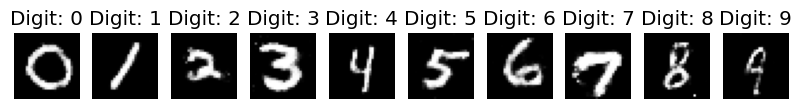

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def generate_class_specific_images(generator, latent_size, number_class, device):
    generator.eval()

    with torch.no_grad():
        z = torch.randn(number_class, latent_size).to(device)
        labels = torch.arange(0, number_class).to(device)

        fake_images = generator(z, labels)
        fake_images = fake_images.view(number_class, 1, 28, 28)
        fake_images = denorm(fake_images)

    plt.figure(figsize=(10, 2))
    for i in range(number_class):
        plt.subplot(1, number_class, i + 1)
        plt.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
        plt.title(f'Digit: {i}')
        plt.axis('off')
    plt.show()

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

generate_class_specific_images(G, latent_size, number_class, device)